<a href="https://colab.research.google.com/github/Harshita-Puthran/factverse/blob/main/application_summarization1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*INSTALL DEPENDENCIES*

In [1]:
!pip install transformers datasets evaluate rouge_score sacrebleu -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Trainer, TrainingArguments
import evaluate

In [3]:
!pip install --no-cache-dir numpy
!pip install --no-cache-dir pandas pyarrow scipy

In [4]:
import pandas as pd
df = pd.read_json("hf://datasets/glnmario/news-qa-summarization/data.jsonl", lines=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
df.head(5)

,story,questions,answers,summary
0,"'SINDH KALAY', England (CNN) -- The aroma of f...","[Where were they being deployed to?, What does...","[[Afghanistan's Helmand province], [how the pe...",British soldiers train in mock Afghan village ...
1,"(AOL Autos) -- At the 2009 Detroit Auto Show,...","[What debuts at the 2009 Detroit Auto Show?, W...","[[electric vehicles], [Chrysler, Mercedes-Benz...",Latest technologies debut at the 2009 Detroit ...
2,(AOL Autos) -- Buying a used car may seem lik...,"[What does Texas have?, What will the average ...",[[has more used vehicles than any other state]...,Three out of four transactions in the U.S. inv...
3,(AOL Autos) -- Collecting cars is an expensiv...,"[What can compete with the Mercedes SL Class?,...","[[Cadillac XLR-V], [hatchback,], [hatchback,],...",The right new car today could be worth a fortu...
4,(AOL Autos) -- Have you ever wondered what yo...,"[what did the report try to uncover?, What do ...",[[secret contents of the average American trun...,Reporter tries to uncover secret contents of a...


In [6]:
print("Number of rows:", len(df))

Number of rows: 10388


In [7]:
df = df.drop(df.index[-1000:]).copy()
print("New size:", len(df))

New size: 9388


In [8]:
import re
from bs4 import BeautifulSoup

def clean_text_extended(text):
    text = str(text)
    # 1. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Fix encoding issues
    text = text.replace("\xa0", " ").replace("&amp;", "&")

    # 3. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # 4. Remove special characters (keep basic punctuation)
    text = re.sub(r"[^a-zA-Z0-9.,;!?()’'\"-]", " ", text)

    # 5. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df["story"] = df["story"].apply(clean_text_extended)
df["summary"] = df["summary"].apply(clean_text_extended)

print(df.head())


                                               story  \
0  'SINDH KALAY', England (CNN) -- The aroma of f...   
1  (AOL Autos) -- At the 2009 Detroit Auto Show, ...   
2  (AOL Autos) -- Buying a used car may seem like...   
3  (AOL Autos) -- Collecting cars is an expensive...   
4  (AOL Autos) -- Have you ever wondered what you...   

                                           questions  \
0  [Where were they being deployed to?, What does...   
1  [What debuts at the 2009 Detroit Auto Show?, W...   
2  [What does Texas have?, What will the average ...   
3  [What can compete with the Mercedes SL Class?,...   
4  [what did the report try to uncover?, What do ...   

                                             answers  \
0  [[Afghanistan's Helmand province], [how the pe...   
1  [[electric vehicles], [Chrysler, Mercedes-Benz...   
2  [[has more used vehicles than any other state]...   
3  [[Cadillac XLR-V], [hatchback,], [hatchback,],...   
4  [[secret contents of the average American t

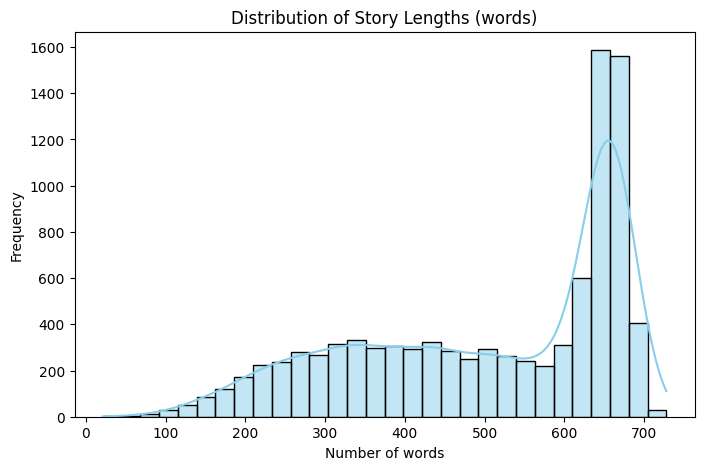

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df['story_len'] = df['story'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df['story_len'], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Story Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


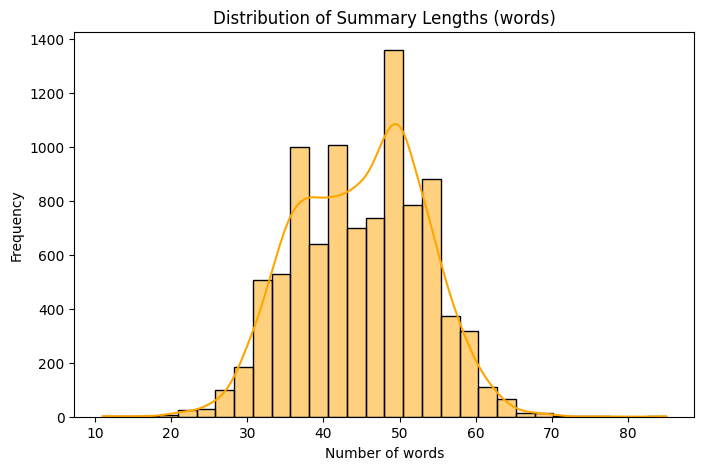

In [10]:
df['summary_len'] = df['summary'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df['summary_len'], bins=30, kde=True, color="orange")
plt.title("Distribution of Summary Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


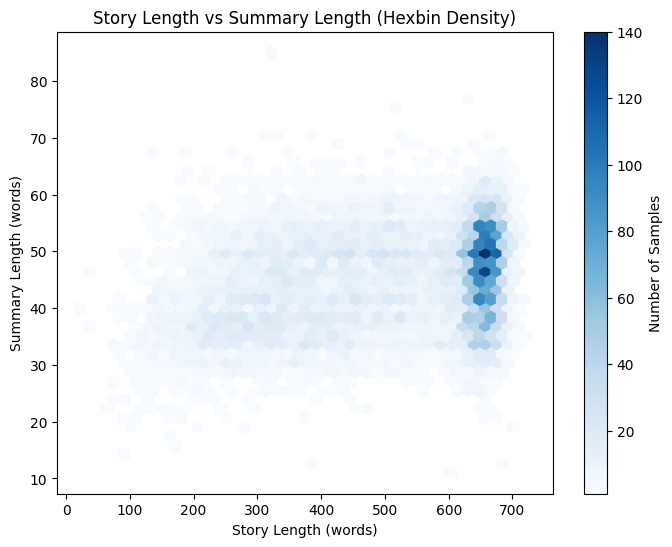

In [11]:
plt.figure(figsize=(8,6))
plt.hexbin(df['story_len'], df['summary_len'], gridsize=40, cmap="Blues", mincnt=1)
plt.colorbar(label="Number of Samples")
plt.title("Story Length vs Summary Length (Hexbin Density)")
plt.xlabel("Story Length (words)")
plt.ylabel("Summary Length (words)")
plt.show()




In [12]:
# Split into train (first 8000) and test (last 1000)
train_df = df.iloc[:8000].copy()
test_df = df.iloc[8000:].copy()

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 8000
Test size: 1388


In [13]:

!pip install transformers datasets torch -q

import pandas as pd
from datasets import load_dataset
from transformers import pipeline
from google.colab import files
from tqdm import tqdm

# 🔹 Load dataset (replace with your dataset path if different)
dataset = load_dataset("glnmario/news-qa-summarization", split="train")
dataset = dataset.select(range(len(dataset) - 5000))

# 🔹 Load summarization model
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

# 🔹 Store results
results = []

# 🔹 Loop over entire dataset
for item in tqdm(dataset, desc="Summarizing"):
    story = item["story"]

    try:
        summary = summarizer(story, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
    except Exception as e:
        summary = f"Error: {e}"

    results.append({"story": story, "summary": summary})

# 🔹 Save to CSV
df = pd.DataFrame(results)
filename = "news_dataset_summaries.csv"
df.to_csv(filename, index=False)

# 🔹 Auto download
files.download(filename)


README.md:   0%|          | 0.00/715 [00:00<?, ?B/s]

data.jsonl:   0%|          | 0.00/40.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10388 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Streaming output truncated to the last 5000 lines.
Summarizing:  31%|███       | 1656/5388 [27:36<1:06:49,  1.07s/it]Your max_length is set to 100, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Summarizing:  51%|█████     | 2742/5388 [46:02<46:57,  1.06s/it]Your max_length is set to 100, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been s

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from evaluate import load

# Load ROUGE
rouge = load("rouge")

# Assuming you already have these two lists ready:
# generated_summaries = [...]
# reference_summaries = [...]

# Compute ROUGE
results = rouge.compute(
    predictions=generated_summaries,
    references=reference_summaries
)

print("ROUGE Evaluation Results:")
print(results)

ROUGE Evaluation Results:
{'rouge1': np.float64(0.3438449109623605), 'rouge2': np.float64(0.14428042058189472), 'rougeL': np.float64(0.24486607982858216), 'rougeLsum': np.float64(0.2979161581901974)}
